# Data Science Using Snowpark for Python and Auto Arima

The purpose of this script is to demonstrate simple data science predictions on Snowflake objects using Snowpark for Python and Auto Arima. The intent is to begin with a Snowflake table containing monthly website sales data spanning multiple categories and create a predictive model to approximate future sales.

Our final process will iterate over both categories in the dataset, before combining the results into a single table.

## Import the various packages

Before we can begin, we must import the required packages.

### Main packages

In [93]:
import pandas
import pmdarima
import snowflake.snowpark

### InterWorks Snowpark package

We must also import the required package from the InterWorks Snowpark package and leverage it to create a Snowflake Snowpark Session object that is connected to our Snowflake environment. Alternatively, you can modify the code to establish a Snowflake Snowpark Session through any method of your choice.

In [94]:
## Import module to build snowpark sessions
from interworks_snowpark.interworks_snowpark_python.snowpark_session_builder import build_snowpark_session_via_parameters_json as build_snowpark_session

## Generate Snowpark session
snowpark_session = build_snowpark_session()

## Retrieve data

Before we can train a model, we must retrieve the data that we wish to leverage.

### Create variables that will be fed into the stored procedure

By creating variables now, we can more easily convert our process to a Stored Procedure later.

In [95]:
origin_table = 'PRODUCT_SALES'
destination_table = 'PRODUCT_SALES_PREDICTIONS'

### Retrieve the data from the source table

In [96]:
df_sales_sf = snowpark_session.table(f'"SALES_DB"."CLEAN"."{origin_table}"') 

df_sales_sf.show()

----------------------------------------
|"SALE_MONTH"  |"CATEGORY"   |"SALES"  |
----------------------------------------
|2005-01-01    |ENTERPRISE   |2114.0   |
|2005-01-01    |PRO EDITION  |2525.0   |
|2005-02-01    |ENTERPRISE   |2109.0   |
|2005-02-01    |PRO EDITION  |2459.5   |
|2005-03-01    |ENTERPRISE   |2366.0   |
|2005-03-01    |PRO EDITION  |2364.75  |
|2005-04-01    |ENTERPRISE   |2300.0   |
|2005-04-01    |PRO EDITION  |2041.5   |
|2005-05-01    |ENTERPRISE   |2569.0   |
|2005-05-01    |PRO EDITION  |2174.25  |
----------------------------------------



### Convert data into a Pandas dataframe

Our current dataframe is a Snowflake dataframe, representing a query to an object in Snowflake. We wish to download this into a Pandas dataframe so that we can manipulate it more freely.

In [98]:
df_sales = pandas.DataFrame(data=df_sales_sf.collect()) \
  .sort_values(by=["SALE_MONTH","CATEGORY" ], ignore_index=True)

display(df_sales)

,SALE_MONTH,CATEGORY,SALES
0,2005-01-01,ENTERPRISE,2114.00
1,2005-01-01,PRO EDITION,2525.00
2,2005-02-01,ENTERPRISE,2109.00
3,2005-02-01,PRO EDITION,2459.50
4,2005-03-01,ENTERPRISE,2366.00
...,...,...,...
403,2021-10-01,PRO EDITION,4535.75
404,2021-11-01,ENTERPRISE,5130.00
405,2021-11-01,PRO EDITION,4659.00
406,2021-12-01,ENTERPRISE,6370.00


### Convert the date field to a Pandas datetime

Since Pandas and Snowflake understand dates differently, we must instruct Pandas to use our treat our SALE_DATE field as a datetime.

In [99]:
df_sales["SALE_MONTH"] = pandas.to_datetime(df_sales["SALE_MONTH"]).dt.tz_localize('UTC')

df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   SALE_MONTH  408 non-null    datetime64[ns, UTC]
 1   CATEGORY    408 non-null    object             
 2   SALES       408 non-null    float64            
dtypes: datetime64[ns, UTC](1), float64(1), object(1)
memory usage: 9.7+ KB


### Filter to a single category

For our development and testing, we restrict our data to a single category. When we later create a stored procedure, we will iterate over our categories to apply this process to each one.

In [125]:
df_sales_enterprise = df_sales[df_sales["CATEGORY"] == "ENTERPRISE"].reset_index(drop=True)

display(df_sales_enterprise)

,SALE_MONTH,CATEGORY,SALES
0,2005-01-01 00:00:00+00:00,ENTERPRISE,2114.0
1,2005-02-01 00:00:00+00:00,ENTERPRISE,2109.0
2,2005-03-01 00:00:00+00:00,ENTERPRISE,2366.0
3,2005-04-01 00:00:00+00:00,ENTERPRISE,2300.0
4,2005-05-01 00:00:00+00:00,ENTERPRISE,2569.0
...,...,...,...
199,2021-08-01 00:00:00+00:00,ENTERPRISE,4898.0
200,2021-09-01 00:00:00+00:00,ENTERPRISE,4598.0
201,2021-10-01 00:00:00+00:00,ENTERPRISE,4737.0
202,2021-11-01 00:00:00+00:00,ENTERPRISE,5130.0


## Create predictive model

Now that we have our data, we are ready to begin constructing our predictive model.

### Test and Train

Split our data into train and test, based on a predictive horizon of 2 years

In [126]:
pred_periods = 24
split_number = df_sales_enterprise['SALES'].count() - pred_periods # corresponds to a prediction horizon of 2 years
df_train     = pandas.DataFrame(df_sales_enterprise['SALES'][:split_number]).rename(columns={'SALES':'y_train'})
df_test      = pandas.DataFrame(df_sales_enterprise['SALES'][split_number:]).rename(columns={'SALES':'y_test' })


### Create Auto Arima model

Leverage Auto Arima to create a model fit.

In [102]:
model_fit = pmdarima.auto_arima(df_train, test='adf', 
                         max_p=3, max_d=3, max_q=3, 
                         seasonal=True, m=12,
                         max_P=3, max_D=2, max_Q=3,
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1965.356, Time=0.53 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2095.397, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2028.985, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1988.738, Time=0.18 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=1969.205, Time=0.51 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=1972.134, Time=0.41 sec
 ARIMA(2,1,2)(2,1,1)[12]             : AIC=1965.659, Time=1.74 sec
 ARIMA(2,1,2)(1,1,2)[12]             : AIC=1966.609, Time=1.70 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=1975.067, Time=0.17 sec
 ARIMA(2,1,2)(0,1,2)[12]             : AIC=1965.204, Time=1.54 sec
 ARIMA(2,1,2)(0,1,3)[12]             : AIC=1965.093, Time=3.57 sec
 ARIMA(2,1,2)(1,1,3)[12]             : AIC=1967.046, Time=4.51 sec
 ARIMA(1,1,2)(0,1,3)[12]             : AIC=1975.676, Time=3.35 sec
 ARIMA(2,1,1)(0,1,3)[12]             : AIC=1972.877, Time=3.55 sec
 ARIMA(3,1,2)(0,1,3

### Summarise model

If desired, the model can be summaries.

In [103]:
print(model_fit.summary())

                                         SARIMAX Results                                          
Dep. Variable:                                          y   No. Observations:                  180
Model:             SARIMAX(2, 1, 2)x(0, 1, [1, 2, 3], 12)   Log Likelihood                -974.546
Date:                                    Thu, 08 Sep 2022   AIC                           1965.093
Time:                                            14:49:22   BIC                           1990.037
Sample:                                                 0   HQIC                          1975.217
                                                    - 180                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1665      0.098    -11.915      0

### Generate in-sample predictions

The parameter `dynamic=False` means that the model makes predictions upon the lagged values. This means that the model is trained until a point in the time-series and then tries to predict the next value.

In [104]:
# Create the predictions
pred = model_fit.predict_in_sample(dynamic=False) # works only with auto-arima
df_train['y_train_pred'] = pandas.to_numeric(pred)

# Calculate the percentage difference
df_train['diff_percent'] = abs((df_train['y_train'] - pred) / df_train['y_train'])* 100

display(df_train)

,y_train,y_train_pred,diff_percent
0,2114.0,0.000000,100.000000
1,2109.0,2104.532841,0.211814
2,2366.0,2109.057922,10.859767
3,2300.0,2367.487361,2.934233
4,2569.0,2296.298755,10.615074
...,...,...,...
175,4480.0,4394.886911,1.899846
176,4434.0,4335.167308,2.228974
177,4437.0,4457.133223,0.453758
178,4674.0,4545.550208,2.748177


### Generate predictions on test data

Generate prediction for n periods. Predictions start from the last date of the training data.

In [105]:
test_pred = model_fit.predict(n_periods=pred_periods, dynamic=False)
df_test['y_test_pred'] = pandas.to_numeric(test_pred)

display(df_test)

,y_test,y_test_pred
180,3728.0,3906.511845
181,3759.0,4091.068029
182,4247.0,4334.391166
183,4251.0,4404.381613
184,4647.0,4696.041008
185,4676.0,4738.672438
186,4798.0,4992.336125
187,4647.0,4757.908434
188,4538.0,4664.657428
189,4536.0,4699.839757


### Combine test and train prediction values with original

In [112]:
df_union = pandas.concat([df_sales_enterprise, df_train, df_test], axis = 1) \
  .rename(columns={'y_train_pred':'TRAIN_PREDICTION', 'y_test_pred': 'TEST_PREDICTION'}) \
  [["SALE_MONTH", "CATEGORY", "SALES", "TRAIN_PREDICTION", "TEST_PREDICTION"]]
 
display(df_union)

,SALE_MONTH,CATEGORY,SALES,TRAIN_PREDICTION,TEST_PREDICTION
0,2005-01-01 00:00:00+00:00,ENTERPRISE,2114.0,0.000000,NaN
1,2005-02-01 00:00:00+00:00,ENTERPRISE,2109.0,2104.532841,NaN
2,2005-03-01 00:00:00+00:00,ENTERPRISE,2366.0,2109.057922,NaN
3,2005-04-01 00:00:00+00:00,ENTERPRISE,2300.0,2367.487361,NaN
4,2005-05-01 00:00:00+00:00,ENTERPRISE,2569.0,2296.298755,NaN
...,...,...,...,...,...
199,2021-08-01 00:00:00+00:00,ENTERPRISE,4898.0,NaN,5024.649376
200,2021-09-01 00:00:00+00:00,ENTERPRISE,4598.0,NaN,4893.146070
201,2021-10-01 00:00:00+00:00,ENTERPRISE,4737.0,NaN,4942.590300
202,2021-11-01 00:00:00+00:00,ENTERPRISE,5130.0,NaN,5153.598519


### Write output back to Snowflake

Upload the data into the Snowflake table.

In [113]:
snowpark_session.write_pandas(
    df = df_union
  , table_name = destination_table
  , schema = 'MART'
  , database = 'SALES_DB'
  , auto_create_table = True
)

## Review and Explore

### Review in-sample test and errors

Review some predictions from the training data. 

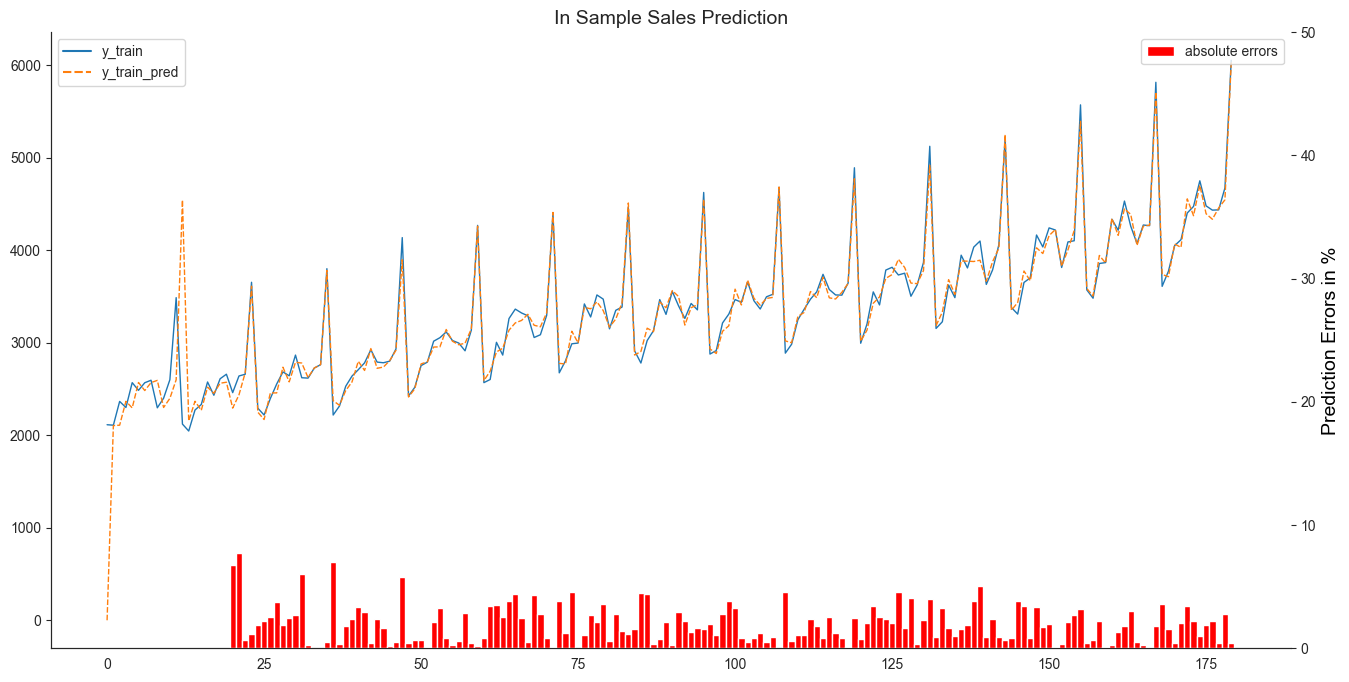

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

# Print the predicted time-series
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("In Sample Sales Prediction", fontsize=14)
sns.lineplot(data=df_train[['y_train', 'y_train_pred']], linewidth=1.0)

# Print percentage prediction errors on a separate axis (ax2)
ax2 = ax1.twinx() 
ax2.set_ylabel('Prediction Errors in %', color='black', fontsize=14)  
ax2.set_ylim([0,50])
ax2.bar(height=df_train['diff_percent'][20:], x=df_train.index[20:], width=1, color='red', label='absolute errors')
plt.legend(['Error %'], loc='upper right')
plt.legend()
plt.show()

### Compare our predictions with the hold-out test set

We can see the 
* The data used for training (blue)
* The hold-out / test set (orange)
* Actual predictions (green)

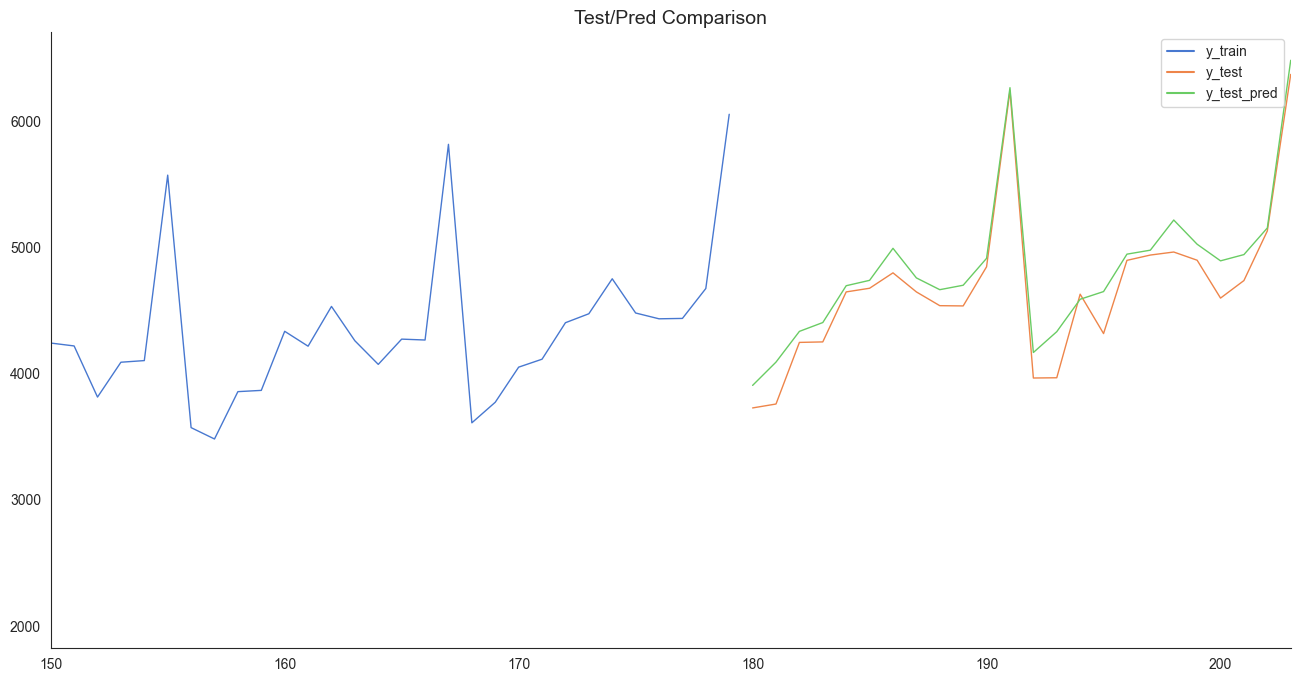

In [115]:
# Generate prediction for n periods, 
# Predictions start from the last date of the training data
test_pred = model_fit.predict(n_periods=pred_periods, dynamic=False)
df_test['y_test_pred'] = test_pred
df_union = pandas.concat([df_train, df_test])

# Print the predicted time-series
fig, ax = plt.subplots(figsize=(16, 8))
plt.title("Test/Pred Comparison", fontsize=14)
sns.despine();
sns.lineplot(data=df_union[['y_train', 'y_test', 'y_test_pred']], linewidth=1.0, dashes=False, palette='muted') # removed y_train_predict
ax.set_xlim([df_union.index[150],df_union.index.max()])
plt.legend()
plt.show()